# Cartesian Cutting Planes 

The standard cutting planes and slices in yt slice along index-space, but in cases when your dataset is defined in non-cartesian coordinates it is useful to sample data on a cartesian plane. This can be accomplished with a `YTCartesianCuttingPlane`, accesible from `ds.cartesian_cutting`. At present it is only implemented for spherical coordinates.

## arbitrary grid data examples

### full spherical domain

We'll start off with an arbitrary uniform grid covering the full range of angular coordinates and radius in (0,1). The following loads data and adds some derived fields for convient plotting: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yt
import unyt
from yt.geometry.coordinates.spherical_coordinates import spherical_to_cartesian

bbox = np.array([[0.0, 1.0], [0, np.pi], [0, 2 * np.pi]])


def _get_slice_func(field_name):
    def _slicing_dim(field, data):
        indx_fld = field_name.split("_")[-1]
        d = data[("index", indx_fld)].d
        return unyt.unyt_array(d, "dimensionless")

    return _slicing_dim


def _z(field, data):
    r = data["index", "r"]
    theta = data["index", "theta"]
    phi = data["index", "phi"]
    _, _, z = spherical_to_cartesian(r, theta, phi)
    return unyt.unyt_array(z, r.units)


shp = (64, 64, 64)
data = {"density": np.random.random(shp)}

ds = yt.load_uniform_grid(
    data,
    shp,
    bbox=bbox,
    geometry="spherical",
    axis_order=("r", "theta", "phi"),
    length_unit="m",
)

for fld in ("theta", "phi", "r"):
    ds.add_field(
        name=("stream", f"dim_{fld}"),
        function=_get_slice_func(f"dim_{fld}"),
        sampling_type="cell",
        units="dimensionless",
        take_log=False,
    )

ds.add_field(name=("index", "z_val"), function=_z, sampling_type="cell", take_log=False)

yt : [INFO     ] 2024-03-25 14:48:04,765 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-25 14:48:04,766 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-03-25 14:48:04,766 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-03-25 14:48:04,767 Parameters: domain_right_edge         = [1.         3.14159265 6.28318531]
yt : [INFO     ] 2024-03-25 14:48:04,767 Parameters: cosmological_simulation   = 0


For initial comparison, let's plot a standard `SlicePlot` in the x-z plane by plotting a slice normal to $\phi$, centered at $\phi=0$. Remember that in yt, $\phi$ is the azimuthal (longitudinal) angle with bounds of (0, $2\pi$) while $\theta$ is the co-latitude with bounds of (0, $\pi$):

yt : [INFO     ] 2024-03-25 14:48:04,856 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-03-25 14:48:04,856 ylim = -1.000000 1.000000
yt : [INFO     ] 2024-03-25 14:48:04,857 Setting origin='native' for spherical geometry.
yt : [INFO     ] 2024-03-25 14:48:04,858 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-03-25 14:48:04,858 ylim = -1.000000 1.000000
yt : [INFO     ] 2024-03-25 14:48:04,859 Making a fixed resolution buffer of (('stream', 'dim_theta')) 800 by 800



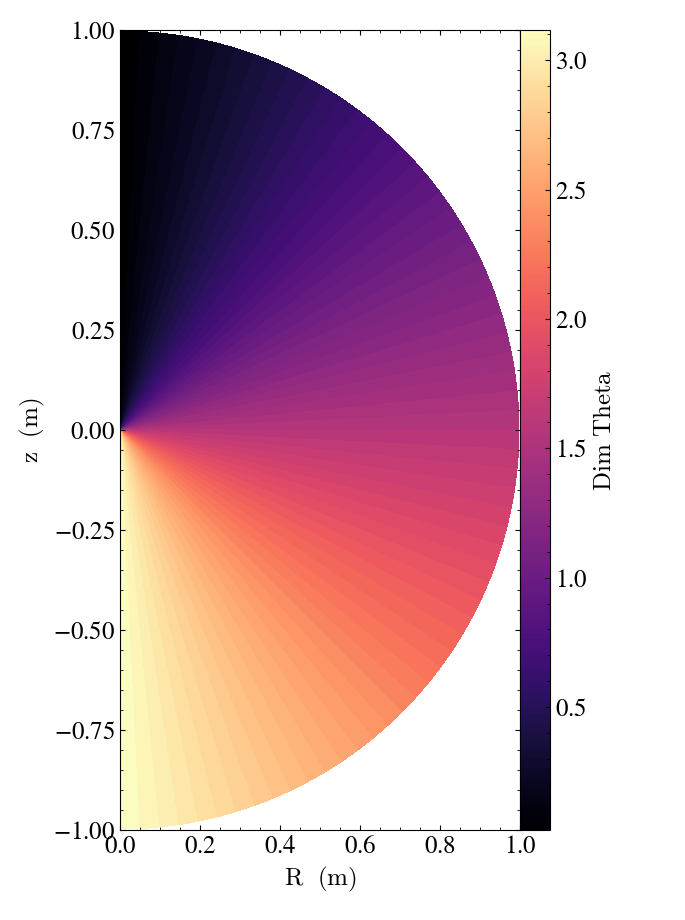

In [2]:
# slice in x-z plane
c = ds.domain_center.copy()
c[2] = 0.0
slc = yt.SlicePlot(ds, "phi", "dim_theta", center=c)
slc.set_cmap("dim_theta", "magma")
slc.show()

because the slice is limited to $\phi=0$, only the positive x axis is displayed.

Now let's create sample the x-z plane with the `YTCartesianCuttingPlane`. 

So, let's set a normal vector defined as the y unit vector and center our plane at the origin. We'll also specify a north vector set to the +z unit vector. 

In [3]:
normal = np.array([0.0, 1.0, 0.0])
center = np.array([0.0, 0.0, 0.0])
north_vector = np.array([0.0, 0.0, 1.0])

slc = ds.cartesian_cutting(normal, center, north_vector=north_vector)

Like all yt data objects, you can extract values from the elements that are intersected by accessing fields:

In [4]:
slc["stream", "density"]

unyt_array([0.29385245, 0.16463203, 0.39649844, ..., 0.77544507, 0.77813165,
       0.24972554], 'code_mass/code_length**3')

**At present, the `YTCartesianCutting` functionality is not integrated into yt's plotting interface, and so plotting is limited to generation of fixed resolution buffers.**

To create a fixed resolution buffer covering $\phi$ at 0 and $\pi$, we'll provide a width of 2 (because our center is at the origin, our image plane will go from +/-1):

In [5]:
frb = slc.to_frb(2.0, 400)

and now we can extract our theta values, masking out points falling outside elements of the grid:

yt : [INFO     ] 2024-03-25 14:48:05,645 Making a fixed resolution buffer of (dim_theta) 400 by 400


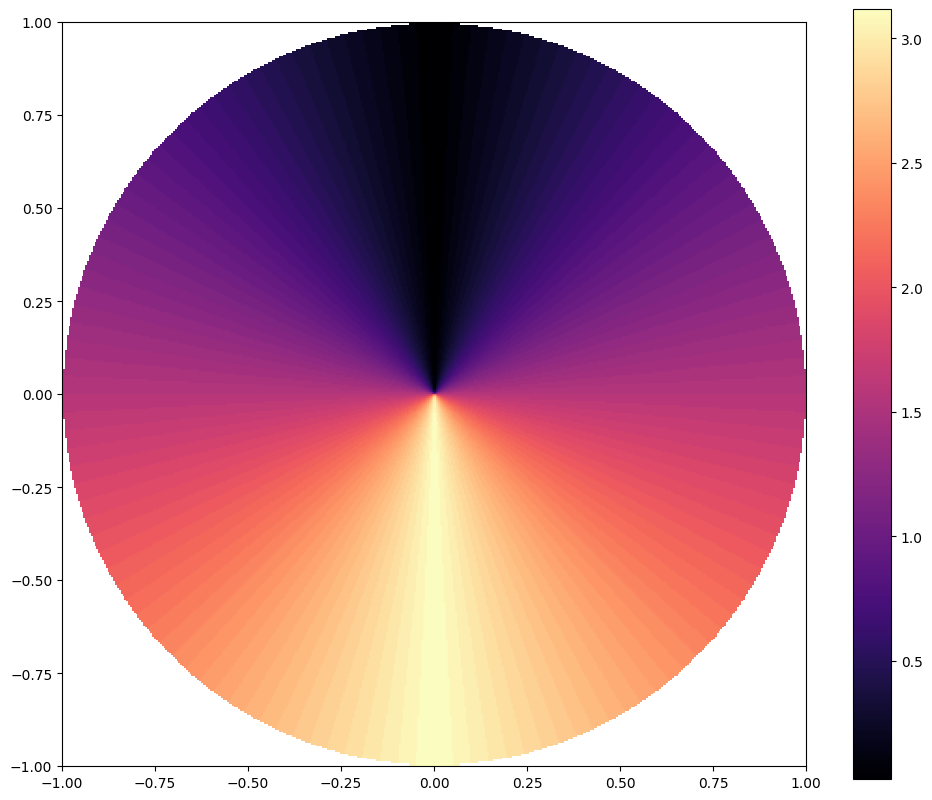

In [6]:
vals = frb["dim_theta"]
vals[~frb.get_mask("dim_theta")] = np.nan
fig = plt.figure(figsize=(12, 10))
plt.imshow(vals, extent=frb.bounds, origin="lower", cmap="magma")
plt.colorbar()
plt.show()

but we can sample arbitrary planes too! 

The following creates a series of slices: each slice is parallel to the x-z plane, with the center shifting across the y axis:

yt : [INFO     ] 2024-03-25 14:48:05,824 Making a fixed resolution buffer of (('index', 'z_val')) 400 by 400
yt : [WARNING  ] 2024-03-25 14:48:05,829 Field ('index', 'z_val') was added without specifying units or dimensions, auto setting units to 'cm'


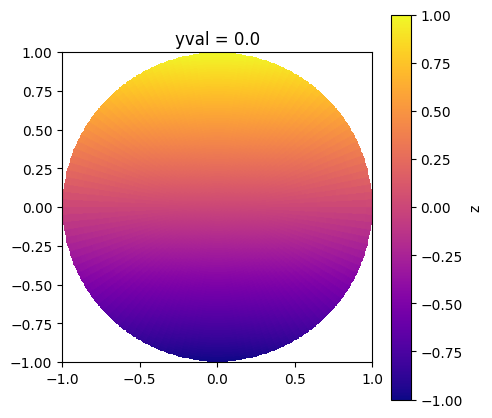

yt : [INFO     ] 2024-03-25 14:48:05,944 Making a fixed resolution buffer of (('index', 'z_val')) 400 by 400


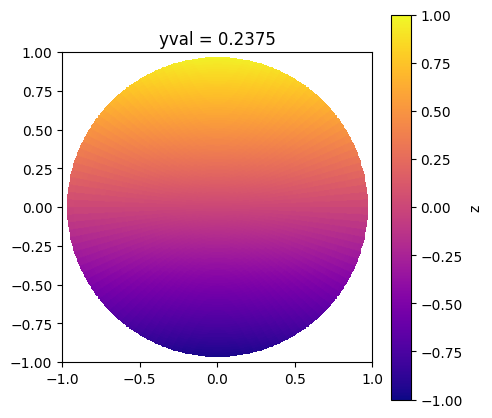

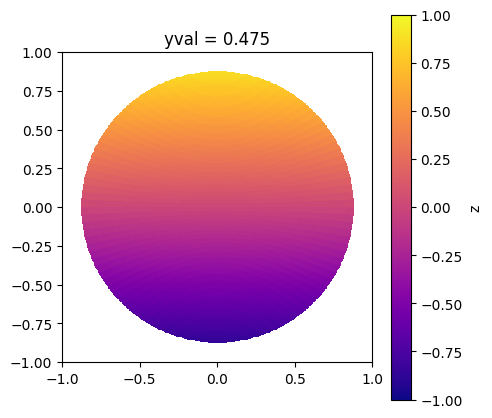

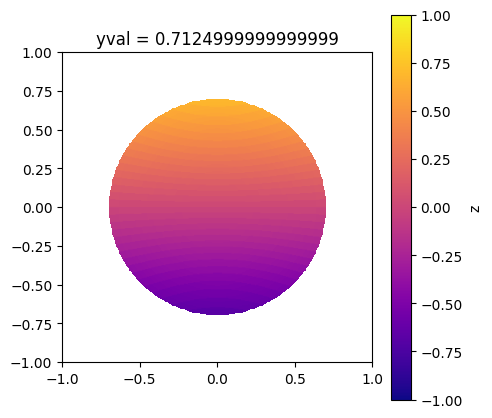

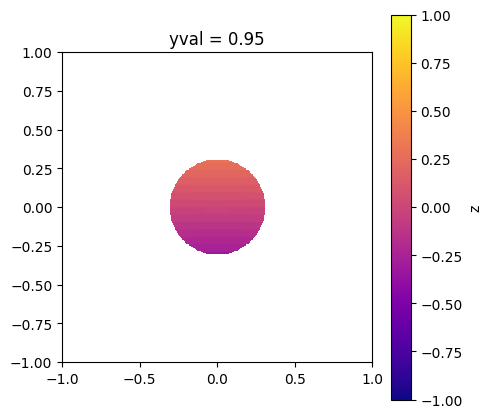

In [7]:
normal = np.array([0.0, 1.0, 0.0])

yvals = np.linspace(0, 0.95, 5)
for yval in yvals:
    center = np.array([0.0, yval, 0.0])
    slc = ds.cartesian_cutting(normal, center)
    frb = slc.to_frb(2.0, 400)

    vals = frb["index", "z_val"]
    vals[~frb.get_mask(("index", "z_val"))] = np.nan

    fig = plt.figure(figsize=(5, 5))
    plt.imshow(
        vals.to("code_length"),
        extent=frb.bounds,
        origin="lower",
        cmap="plasma",
        clim=(-1, 1),
    )
    plt.title(f"yval = {yval}")
    c = plt.colorbar()
    c.set_label("z")
    plt.show()

### cross sections

Like other yt data objects, the `YTCartesianCuttingPlane` accepts a `data_source` argument. This allows you to easily create a cross section by limiting the cutting plane by a region object. 

First, create a region that samples a smaller region of the dataset:

In [8]:
left_edge = ds.arr([0.5, 30 * np.pi / 180, 20 * np.pi / 180], "code_length")
right_edge = ds.arr([0.9, 60 * np.pi / 180, 40 * np.pi / 180], "code_length")
c = (left_edge + right_edge) / 2.0

region = ds.region(c, left_edge, right_edge)

now, define a start and end point. We'll construct a plane by taking the vectors defined by distance between the origin and each point and calculating a normal. In this case, we'll fix $\phi$ and $r$ and vary $\theta$ only:

In [9]:
pt1 = np.array([0.9, left_edge[1].d, c[2].d])
pt2 = np.array([0.9, right_edge[1].d, c[2].d])

now, let's convert all our points to cartesian, calculate the normal vector and set the center point. Additionally, we'll provide a north vector pointing towards the center so that our cross-section image is oriented "up": 

In [10]:
pts = np.column_stack([pt1, pt2, c.d])
x, y, z = spherical_to_cartesian(pts[0, :], pts[1, :], pts[2, :])

normal = -np.cross((x[0], y[0], z[0]), (x[1], y[1], z[1]))
center = np.array([x[2], y[2], z[2]])
north_vector = center

now contstruct the plane and create an FRB and we'll have our cross section!

yt : [INFO     ] 2024-03-25 14:48:06,542 Making a fixed resolution buffer of (dim_theta) 400 by 400


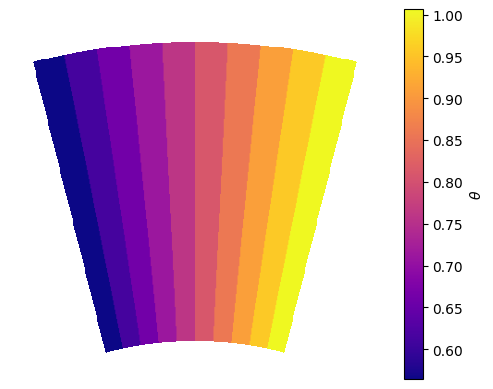

In [11]:
slc = ds.cartesian_cutting(
    normal, center, north_vector=north_vector, data_source=region
)
frb = slc.to_frb(0.5, 400)

vals = frb["dim_theta"]
vals[~frb.get_mask("dim_theta")] = np.nan

fig, axs = plt.subplots(1)
im = axs.imshow(
    vals,
    extent=frb.bounds,
    origin="lower",
    cmap="plasma",
)
axs.axes.axes.set_axis_off()
c = plt.colorbar(im)
c.set_label(r"$\theta$")
plt.show()

### slices through a limited domain

The slicing works just as well for datasets that do not span the full spherical domain

yt : [INFO     ] 2024-03-25 14:48:06,638 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-25 14:48:06,638 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2024-03-25 14:48:06,638 Parameters: domain_left_edge          = [0.5        0.52359878 0.34906585]
yt : [INFO     ] 2024-03-25 14:48:06,639 Parameters: domain_right_edge         = [1.         1.04719755 0.6981317 ]
yt : [INFO     ] 2024-03-25 14:48:06,639 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-03-25 14:48:06,679 Making a fixed resolution buffer of (dim_theta) 600 by 600


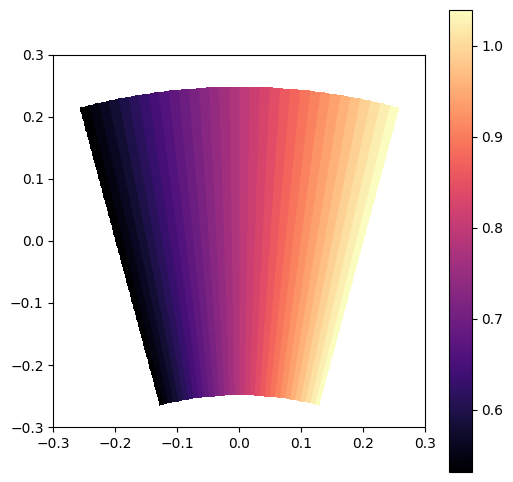

In [12]:
bbox = np.array([[0.5, 1.0], [30, 60], [20, 40]])
bbox[1:, :] = bbox[1:, :] * np.pi / 180  # convert angle ranges to radians


shp = (32, 32, 32)
data = {"density": np.random.random(shp)}

ds = yt.load_uniform_grid(
    data,
    shp,
    bbox=bbox,
    geometry="spherical",
    axis_order=("r", "theta", "phi"),
    length_unit="m",
)

for fld in ("theta", "phi", "r"):
    ds.add_field(
        name=("stream", f"dim_{fld}"),
        function=_get_slice_func(f"dim_{fld}"),
        sampling_type="cell",
        units="dimensionless",
        take_log=False,
    )

phi_val = ds.domain_center.d[2]
pt1 = np.array([1.0, ds.domain_left_edge[1].d, phi_val])
pt2 = np.array([1.0, ds.domain_right_edge[1].d, phi_val])
c = np.array([0.75, ds.domain_center[1].d, phi_val])

pts = np.column_stack([pt1, pt2, c])
x, y, z = spherical_to_cartesian(pts[0, :], pts[1, :], pts[2, :])
normal = -np.cross((x[0], y[0], z[0]), (x[1], y[1], z[1]))
center = np.array([x[2], y[2], z[2]])
north_vector = center

slc = ds.cartesian_cutting(normal, center, north_vector=north_vector)
frb = slc.to_frb(0.6, 600)
vals = frb["dim_theta"]
vals[~frb.get_mask("dim_theta")] = np.nan
fig = plt.figure(figsize=(6, 6))
plt.imshow(vals, extent=frb.bounds, origin="lower", cmap="magma")
plt.colorbar()
plt.show()

### a note on "edge tolerance"

The way the fixed resolution buffer is constructed involves converting from the in-plane x-y coordinates to spherical coordinates. This introduces a bit of error, and when calculating whether a point on the image buffer falls within a spherical element, sometimes that small error causes that check to fail. 

To avoid this issue, a small tolerance factor, `edge_tol` is added within the pixelization routine. Depending on the size of a grid's elements and the resolution of the image buffer, this tolerance may need to be adjusted so it is exposed as a keyword argument to `ds.cutting_mixed`. 

We can demonstrate it's effect by setting the `edge_tol` to 0.0: 

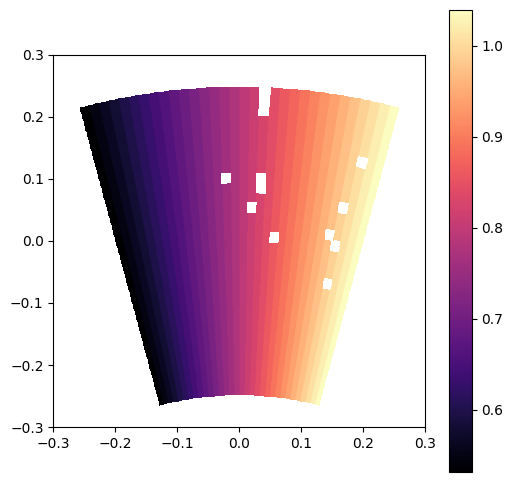

In [13]:
slc = ds.cartesian_cutting(normal, center, north_vector=north_vector, edge_tol=0.0)
frb = slc.to_frb(0.6, 600)
vals = frb["dim_theta"]
vals[~frb.get_mask("dim_theta")] = np.nan

fig = plt.figure(figsize=(6, 6))
plt.imshow(vals, extent=frb.bounds, origin="lower", cmap="magma")
plt.colorbar()
plt.show()

The blank pixels are spots where the rounding error cause a pixel to fail a bounds check for an element. Increasing the edge tolerance will fill in those pixels (the default is 1e-12).

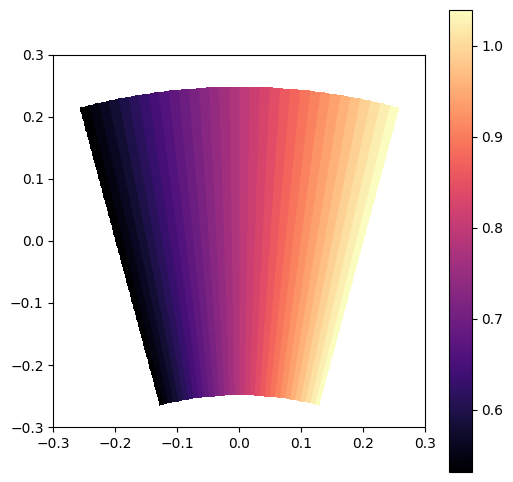

In [14]:
slc = ds.cartesian_cutting(normal, center, north_vector=north_vector, edge_tol=1e-8)
frb = slc.to_frb(0.6, 600)
vals = frb["dim_theta"]
vals[~frb.get_mask("dim_theta")] = np.nan

fig = plt.figure(figsize=(6, 6))
plt.imshow(vals, extent=frb.bounds, origin="lower", cmap="magma")
plt.colorbar()
plt.show()

increasing it **too** much will start to blur adjacent elements and find values where there shouldn't be:

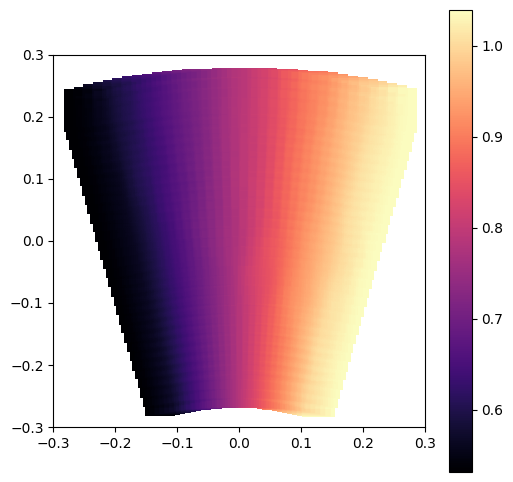

In [15]:
slc = ds.cartesian_cutting(normal, center, north_vector=north_vector, edge_tol=1e-1)
frb = slc.to_frb(0.6, 600)
vals = frb["dim_theta"]
vals[~frb.get_mask("dim_theta")] = np.nan

fig = plt.figure(figsize=(6, 6))
plt.imshow(vals, extent=frb.bounds, origin="lower", cmap="magma")
plt.colorbar()
plt.show()

## example with an actual (sample) dataset

Now let's try it out using an actual dataset, KeplerianDisk.

In [16]:
ds = yt.load_sample("KeplerianDisk")

yt : [INFO     ] 2024-03-25 14:48:07,383 Sample dataset found in '/Users/chavlin/data/yt_data/KeplerianDisk/disk.out1.00000.athdf'
yt : [WARNING  ] 2024-03-25 14:48:07,449 Assuming 1.0 = 1.0 cm
yt : [WARNING  ] 2024-03-25 14:48:07,449 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2024-03-25 14:48:07,449 Assuming 1.0 = 1.0 g
yt : [WARNING  ] 2024-03-25 14:48:07,450 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2024-03-25 14:48:07,479 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-25 14:48:07,480 Parameters: domain_dimensions         = [256  64   4]
yt : [INFO     ] 2024-03-25 14:48:07,480 Parameters: domain_left_edge          = [0.3        1.17809725 0.        ]
yt : [INFO     ] 2024-03-25 14:48:07,480 Parameters: domain_right_edge         = [3.         1.96349541 6.28318531]
yt : [INFO     ] 2024-03-25 14:48:07,480 Parameters: cosmological_simulation   = 0


for reference, a phi-normal slice at phi=0, normal to the x-z plane looks like

yt : [INFO     ] 2024-03-25 14:48:07,627 xlim = 0.277164 3.000000
yt : [INFO     ] 2024-03-25 14:48:07,627 ylim = -1.148050 1.148050
yt : [INFO     ] 2024-03-25 14:48:07,628 Setting origin='native' for spherical geometry.
yt : [INFO     ] 2024-03-25 14:48:07,629 xlim = 0.277164 3.000000
yt : [INFO     ] 2024-03-25 14:48:07,629 ylim = -1.148050 1.148050
yt : [INFO     ] 2024-03-25 14:48:07,630 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



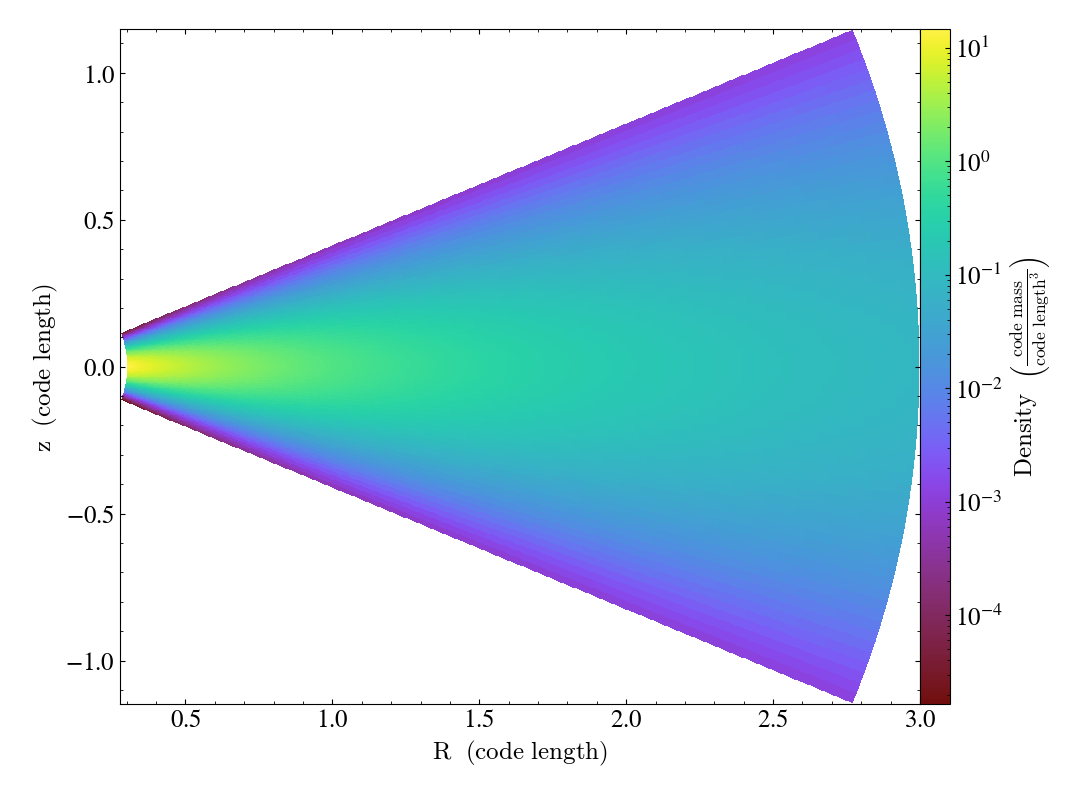

In [17]:
yt.SlicePlot(ds, "phi", "density", center=ds.arr([0.0, 0.0, 0.0], "code_length"))

now with the mixed-coord cutting plane, but spanning both phi = 0 and pi

yt : [INFO     ] 2024-03-25 14:48:08,196 Making a fixed resolution buffer of (('athena_pp', 'dens')) 800 by 800


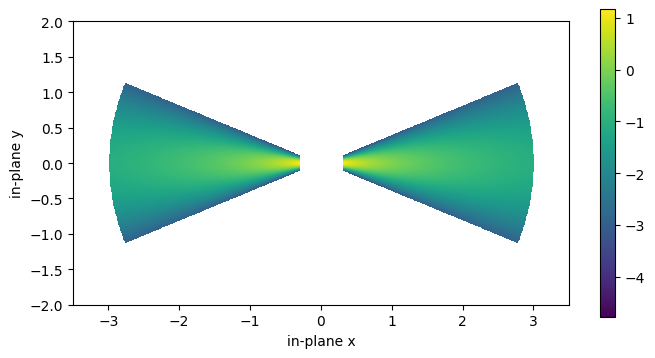

In [18]:
normal = np.array([0.0, 1.0, 0.0])
plane_center = np.array([0.0, 0.0, 0.0])
slc = ds.cartesian_cutting(normal, plane_center)

frb = slc.to_frb(7.0, 800, height=4.0)
bvals = frb[("athena_pp", "dens")]

# mask out empty values for plotting
mask = frb.get_mask(("athena_pp", "dens"))
bvals[~mask] = np.nan

f = plt.figure(figsize=(8, 4))
plt.imshow(np.log10(bvals), extent=frb.bounds, origin="lower", cmap="viridis")
plt.xlabel("in-plane x")
plt.ylabel("in-plane y")
plt.colorbar()

and now a slice parallel to the x-y plane, centered at (0,0,0.5):

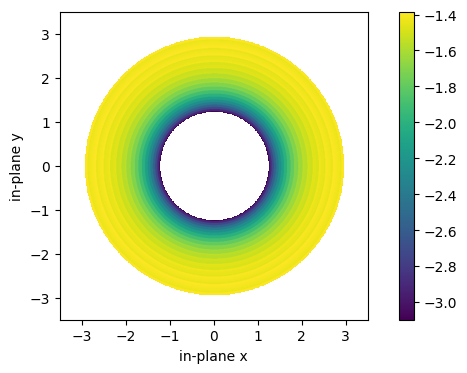

In [19]:
normal = np.array([0.0, 0.0, 1.0])
plane_center = np.array([0.0, 0.0, 0.5])
slc = ds.cartesian_cutting(normal, plane_center)
frb = slc.to_frb(7.0, 800)

bvals = frb[("athena_pp", "dens")]
mask = frb.get_mask(("athena_pp", "dens"))
bvals[~mask] = np.nan

# plot it
f = plt.figure(figsize=(8, 4))
plt.imshow(np.log10(bvals), extent=frb.bounds, origin="lower")
plt.xlabel("in-plane x")
plt.ylabel("in-plane y")
plt.colorbar()